In [1]:
import numpy as np
from random import randrange
import matplotlib.pyplot as plt

In [2]:
def load_intervals(fname):
    Lines = []
    with open(fname, "r") as f:
        Lines = f.readlines()
    
    data = {}
    for line in Lines:
        name, intervals = line.split("\t")
        assert name not in data
        data[name] = {"left": [], "right": [], "var": {}}
        isLeft = True
        for break_pt in intervals.split():
            assert break_pt.isdecimal()
            if isLeft:
                data[name]["left"].append(int(break_pt))
            else:
                data[name]["right"].append(int(break_pt))
            isLeft = not isLeft
        
        temp_right = np.array(data[name]["right"]) / 1000
        temp_left = np.array(data[name]["left"]) / 1000
        data[name]["var"] = {"left": np.var(temp_left), "right": np.var(temp_right)}
    return data

In [3]:
intervl_data = load_intervals("top_oncogene_intervals.txt")

In [4]:
def oncogene_loader(fname):
    Lines = []
    with open(fname, "r") as f:
        Lines = f.readlines()
        
    gene_data = {}
    for line in Lines[1:-1]:
        temp = line.split(",")
        gene_name  = temp[0].replace('"', '')
        left_pt = int(temp[2])
        right_pt = int(temp[3])
        if gene_name not in gene_data:
            gene_data[gene_name] = {"left": [], "right": []}
        gene_data[gene_name]["left"].append(left_pt)
        gene_data[gene_name]["right"].append(right_pt)
    return gene_data

In [5]:
oncogene_data = oncogene_loader("oncogene_tissue_type.csv")

In [6]:
def generat_vars(num_var, gene, data, oncogene_data, bp_unit=1000):
    results = []
    if gene not in oncogene_data:
        print(gene + " not in oncogene_data")
        return result
    for v in range(num_var):
        rand_intervals = {"left": [], "right": []}
        for i in range(len(data[gene]["left"])):
            interval_len = data[gene]["right"][i] - data[gene]["left"][i]
            #assert len(oncogene_data[gene]["right"]) == 1
            #if not (data[gene]["left"][i] <= oncogene_data[gene]["left"][0] and data[gene]["right"][i] >= oncogene_data[gene]["right"][0]):
            #    print(str(data[gene]["right"][i]) + " | " + str(data[gene]["left"][i]))
            #    print(data[gene]["right"][i] - data[gene]["left"][i])
            gene_len = oncogene_data[gene]["right"][0] - oncogene_data[gene]["left"][0]
            if gene_len > interval_len:
                continue
            shift_range = int(interval_len - (gene_len / 3))
            shift = int(randrange(shift_range) - (gene_len / 3))
            left_pt = oncogene_data[gene]["left"][0] - shift
            right_pt = oncogene_data[gene]["right"][0] - shift
            rand_intervals["left"].append(left_pt)
            rand_intervals["right"].append(right_pt)
        var = np.var(np.array(rand_intervals["left"]) / bp_unit) + np.var(np.array(rand_intervals["right"]) / bp_unit)
        results.append(var)
    return results

In [21]:
def plot_hist(random_var_list, target_var, gene_name, num_rand, num_bins, bin_size):
    ranges = np.array(range(num_bins)) * bin_size
    hist = np.zeros(num_bins)
    target_bin = num_bins - 1
    for i in range(num_bins-1):
        if target_var <= ranges[i + 1]:
            target_bin = i
            break
    for var in random_var_list:
        found = False
        for i in range(num_bins-1):
            if var <= ranges[i + 1]:
                hist[i] += 1
                found = True
                break
        if not found:
            hist[-1] += 1
    y = []
    for i in range(num_bins-1):
        y.append(str(i) + "-" + str(i+1))
    y.append(str(num_bins-1) + "-")
    colors = ["blue"] * num_bins
    colors[target_bin] = "red"
    plt.bar(y, hist, color=colors)
    plt.title("Distribution of " + str(num_rand) + " randomly shifted interval variances(left + right),\n red bar contains real variance for gene: " + gene_name) 
    plt.xlabel("ranges of variance (in terms of " + str(bin_size) + ")")  
    plt.ylabel("Number of variance occurrence in certain range")
    plt.show()

In [22]:
def analyze_significance(gene_name, intervl_data, oncogene_data, num_rand=1000, num_bins=10, bin_size=100000):
    random_generated_vars = generat_vars(num_rand, gene_name, intervl_data, oncogene_data)
    target_var = intervl_data[gene_name]["var"]["left"] + intervl_data[gene_name]["var"]["right"]
    plot_hist(random_generated_vars, target_var, gene_name, num_rand, num_bins, bin_size)

## PVT1

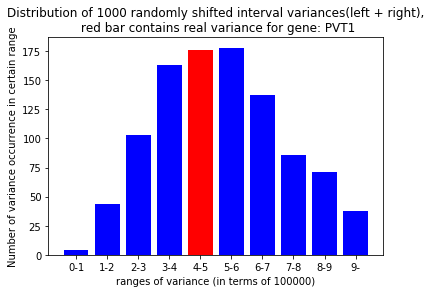

In [17]:
analyze_significance("PVT1", intervl_data, oncogene_data)

## TBC1D3C

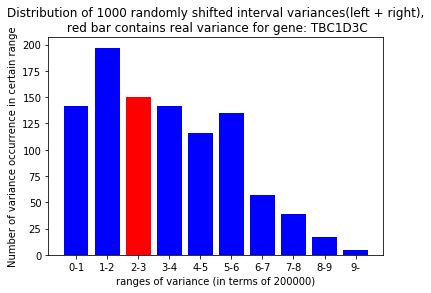

In [23]:
analyze_significance("TBC1D3C", intervl_data, oncogene_data, num_bins=10, bin_size=200000)

## EGFR

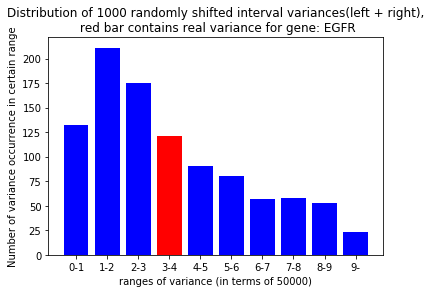

In [24]:
analyze_significance("EGFR", intervl_data, oncogene_data, num_bins=10, bin_size=50000)

In [ ]:
#243922 / (oncogene_data["PVT1"]["right"][0] - oncogene_data["PVT1"]["left"][0])